In [1]:
"""
This file takes likert_data.csv as input, conduct analysis on within-subject correlation and inter class correlation
"""
import json
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from os.path import basename
from scipy.stats import spearmanr

In [2]:
input_path = 'likert_data.csv'

likert_data = pd.read_csv(input_path, index_col=0)  # shape = (3732, 6)
print likert_data.shape
likert_data.head()

(910, 7)


,subId,rt,imgName,isRepeat,rating,trial_index,debug_mode
0,debugKXH3HJ:debugFOUV4M,1860,/static/images/2kfaces/Google_1_Paul Reno_1_ov...,0,5,6,debug
1,debugKXH3HJ:debugFOUV4M,4852,/static/images/2kfaces/Google_1_Norman Westfal...,0,5,8,debug
2,debugKXH3HJ:debugFOUV4M,77811,/static/images/2kfaces/Google_1_Sara Guajardo_...,0,5,10,debug
3,debugKXH3HJ:debugFOUV4M,4087,/static/images/2kfaces/Google_1_Sherry Mcmicha...,0,5,12,debug
4,debugKXH3HJ:debugFOUV4M,3030,/static/images/2kfaces/Google_1_Gertrude Bayne...,0,5,14,debug


In [3]:
likert_data = likert_data[likert_data['debug_mode']!='debug']
print likert_data.shape

(900, 7)


In [4]:
sub_num_dict = {}
sub_counter = 1
for sub_id in likert_data['subId']:
    if sub_id not in sub_num_dict:
        sub_num_dict[sub_id] = sub_counter
        sub_counter += 1
likert_data['subNum'] = likert_data['subId'].map(sub_num_dict)

img_num_dict = {}
img_counter = 0
for img_name in likert_data['imgName']:
    if img_name not in img_num_dict:
        img_num_dict[img_name] = img_counter
        img_counter += 1
        
likert_data['imgNum'] = likert_data['imgName'].map(img_num_dict)

new_df = likert_data.sort_values(by=['subNum','isRepeat', 'imgNum'], ascending=True)
new_df.drop(columns=['subId', 'imgName'], inplace=True)
new_df = new_df[['subNum', 'imgNum', 'isRepeat', 'rating', 'rt']] 

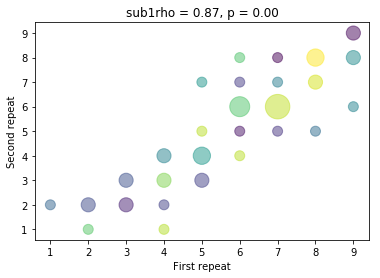

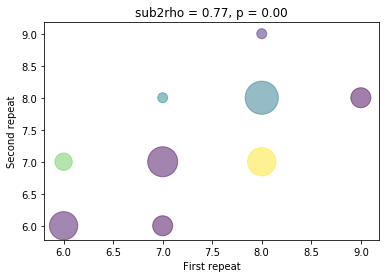

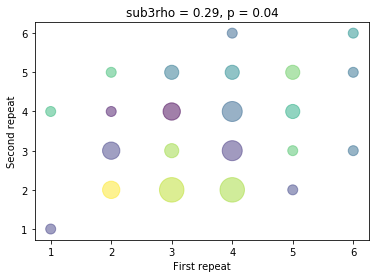

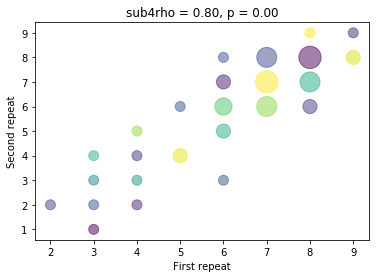

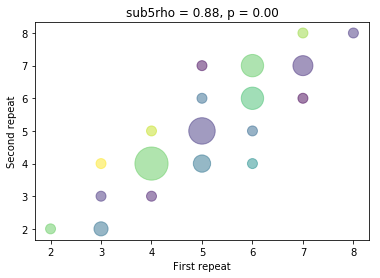

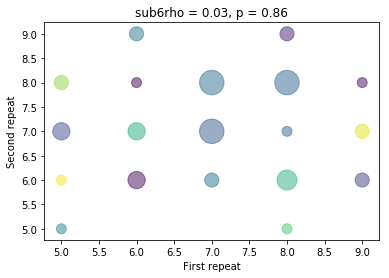

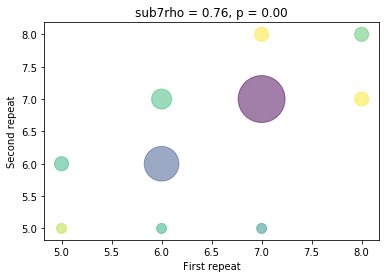

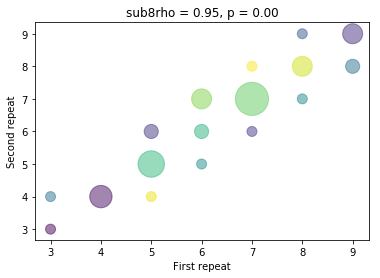

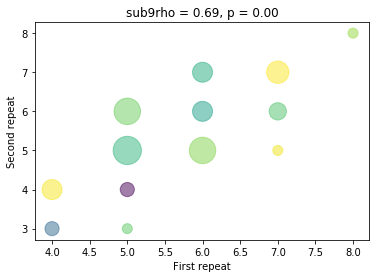

In [5]:
for cur_sub_id in range(1, len(new_df['subNum'].unique())+1):
    cur_sub_data = new_df[new_df['subNum']==cur_sub_id]
    
    empty = cur_sub_data[cur_sub_data['imgNum']==0]['rating'].values
    
    cur_sub_data = cur_sub_data[cur_sub_data['imgNum']!=0]

    
    cur_data_length = len(cur_sub_data)
    unique_trial_num = cur_data_length / 2
    if cur_data_length % 2 !=0:
        raise Exception('the data length should be divisble by 2.')
        
    first_half = cur_sub_data.head(unique_trial_num)['rating'].values
    second_half = cur_sub_data.tail(unique_trial_num)['rating'].values
    rho, p = spearmanr(first_half, second_half)
#     if p > 0.05:
#         print('sub id = {}, empty = {}, ave = {:.1f}, std = {:.1f}, rho = {:.1f}, p = {:.1f}'.
#               format(cur_sub_id, empty, cur_sub_data['rating'].mean(), cur_sub_data['rating'].std(), rho, p))
    
    unique_coor = sorted(set(zip(first_half, second_half)))
    total_coor = list(zip(first_half, second_half))
    
    size = []
    
    for coor in unique_coor:
        size.append(total_coor.count(coor))
    
    x_unique_coor, y_unique_coor = zip(*unique_coor)
    
    colors = np.random.rand(len(x_unique_coor))
    
    plt.title('sub' + str(cur_sub_id)+'rho = {:.2f}, p = {:.2f}'.format(rho, p))
    plt.xlabel('First repeat')
    plt.ylabel('Second repeat')
    plt.scatter(x_unique_coor, y_unique_coor, s=np.array(size)*100, alpha=0.5, c=colors)
    plt.show()
    

In [33]:
# compute first pilot and second pilot separately. 

throw_away_counter = 0
group_rating_matrix = []  # 40 (faces) * 25 (subjects)


for cur_sub_id in range(1, len(new_df['subNum'].unique())+1):
    cur_sub_data = new_df[new_df['subNum']==cur_sub_id]
#     cur_sub_data = cur_sub_data[cur_sub_data['imgNum']!=0]

    cur_data_length = len(cur_sub_data)
    unique_trial_num = cur_data_length / 2
    

    if cur_data_length % 2 !=0:
        raise Exception('the data length should be divisble by 2.')

    first_half = cur_sub_data.head(unique_trial_num)['rating'].values ## 40 * 1
    second_half = cur_sub_data.tail(unique_trial_num)['rating'].values  # 40 * 1

    rho, p = spearmanr(first_half, second_half)

    if p > 0.01: 
        throw_away_counter += 1
        print('Throw away current subject{}'.format(cur_sub_id))
    else:
#         ave_rating = (first_half + second_half) / 2.0
#         group_rating_matrix.append(ave_rating)
        group_rating_matrix.append(cur_sub_data['rating'].values)
            
group_rating_array = np.array(group_rating_matrix) 

print group_rating_array.shape
group_rating_array = np.transpose(group_rating_array)
print group_rating_array.shape
np.savetxt("pilot2_data.csv", group_rating_array, delimiter=",")

Throw away current subject3
Throw away current subject6
(7, 100)
(100, 7)


0.6602896515260082 7.822994247298367e-14
random sub3


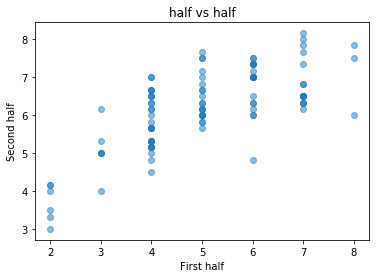

In [39]:
total_sub_num = group_rating_array.shape[1]
rand_seed = np.random.permutation(total_sub_num)
test_array = group_rating_array[:, rand_seed]
group_half1 = test_array[:, 0]
group_half2 = test_array[:, 1:]
# print group_half1.shape, group_half2.shape

# av1 = np.mean(group_half1, axis=1)
# print av1.shape
av1 = group_half1
av2 = np.mean(group_half2, axis=1)

rho, p = spearmanr(av1, av2)
print rho, p
print 'random sub' + str(rand_seed[0] )
plt.title('half vs half')
plt.xlabel('First half')
plt.ylabel('Second half')
plt.scatter(av1, av2, alpha=0.5)
plt.show()

## test-retest 

In [42]:
# compute first pilot and second pilot separately. 

valid_counter = 0
group_rating_matrix = []  # 40 (faces) * 25 (subjects)


for cur_sub_id in range(1, len(new_df['subNum'].unique())+1):
    cur_sub_data = new_df[new_df['subNum']==cur_sub_id]
#     cur_sub_data = cur_sub_data[cur_sub_data['imgNum']!=0]

    cur_data_length = len(cur_sub_data)
    unique_trial_num = cur_data_length / 2
    

    if cur_data_length % 2 !=0:
        raise Exception('the data length should be divisble by 2.')

    first_half = cur_sub_data.head(unique_trial_num)['rating'].values ## 40 * 1
    second_half = cur_sub_data.tail(unique_trial_num)['rating'].values  # 40 * 1

    rho, p = spearmanr(first_half, second_half)

    if rho > 0.9: 
        valid_counter += 1
#         print('Throw away current subject{}'.format(cur_sub_id))
    else:
#         ave_rating = (first_half + second_half) / 2.0
#         group_rating_matrix.append(ave_rating)
        group_rating_matrix.append(cur_sub_data['rating'].values)
        
print valid_counter
# group_rating_array = np.array(group_rating_matrix) 

# print group_rating_array.shape
# group_rating_array = np.transpose(group_rating_array)
# print group_rating_array.shape
# np.savetxt("pilot2_data.csv", group_rating_array, delimiter=",")

1
